# LINHA <> - Caderno de Operação

## Caderno de Inicialização e Calibração inicial da Linha de Luz

### Técnico responsável:

Texto inicial










## Notebook Initialization

The next cell loads the <b><i>util.ipynb</i></b> notebook, which provides functions and classes to connect the IJupyter and EPICS interfaces.

<sup><sup>Any bug or unexpected behavior from any of these functions and classes, please contact SOL.</sup></sup>

In [2]:
import io, os, sys, types
from IPython import get_ipython
import nbformat
from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, nbformat.NO_CONVERT)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
from util import *

importing Jupyter notebook from util.ipynb


## Configuration Cell

Check the boxes to set some notebook's configuration

In [7]:
checkbox_logprint_in_cell = widgets.Checkbox(
    value=False,
    description="Print log in Notebook's cells",
    disabled=False,
    style={'description_width': 'initial'},
)

config = {"log_cell": checkbox_logprint_in_cell}

output = widgets.Output()

@output.capture()
def change_checkbox_logprint_in_cell(change):
    logprint("Changed Logprint Checkbox to: " + str(change.new))
    
checkbox_logprint_in_cell.observe(change_checkbox_logprint_in_cell, 'value')

box = widgets.VBox([checkbox_logprint_in_cell, output])

display(box)



## Motor Calibration

### Write in the Text Box, separated by spaces, every motor name that should be initialized.

###### PS: Do not use any other character separation other than spaces!

In [ ]:
config

In [ ]:
start_motor_button_box = StartMotorsButton(config)
start_motor_button_box.display_start_button()

### Write in the "Number Text Box" the absolute target value desired for the motor 

In [ ]:
start_motor_button_box.display_motors_targ_buttons()

### Write in the Text Box, separated by spaces, every motor PV name that should be monitored.

###### PS: Do not use any other character separation other than spaces!

In [ ]:
motor_monitor = MotorsMonitor(config)
motor_monitor.display_monitor_motors()

In [ ]:
# from py4syn.utils.scan import scan
# scan(cnew_motor, 10, 5, 10, 0.1)

In [ ]:
pv_monitor = PVMonitor(config)
pv_monitor.display_monitor_pvs()

## Call Scan

## Plotting data

### Plotly

Plotly is a great library for plotting data in a Jupyter Notebook.

Informations and examples of how to use this library can be found in https://plot.ly/python/


#### Simple scatter plot example:

In [ ]:
# Enable offline plots from plotly
py.init_notebook_mode(connected=True)

# Read sample csv file with pandas library (CSV example obatained from https://catalog.data.gov/dataset/age-adjusted-death-rates-for-the-top-10-leading-causes-of-death-united-states-2013/resource/0e603f1d-31bf-4809-8f10-a994b305b379)
df = pd.read_csv('sample-data.csv')

# Let's plot the number of total deaths for every USA state
data = df.groupby('State').sum().reset_index()

# Looking at our data, there is a United States row that includes the sum of all states, we should remove this row
for i in range(len(data.index) - 1):
    if data.iloc[i]['State'] == 'United States':
        data = data.drop(i, axis=0)

# Create a Scatter graph
trace1 = go.Scatter(
                    x=data['State'], y=data['Deaths'], # Data
                    mode='lines+markers', name='logx' # Additional options
                   )

# Create a Layout for the graph
layout = go.Layout(title='Number of deaths for every USA State',
                   plot_bgcolor='rgb(230, 230, 230)')

# Create a figure to be plotted
fig = go.FigureWidget(data=[trace1], layout=layout)

# Plot figure in the notebook
df.columns

In [11]:
import json
import os
import threading
from IPython.display import display
import ipywidgets as widgets
import time
import pandas


class MonitorScanSave(widgets.Button):
    
    def __init__(self, config, *args, **kwargs):
        widgets.Button.__init__(self, *args, **kwargs)
        
        # Config
        self.config = config
        
        # class Button values for MonitorScanSave
        self.description='Start Scanning Plot'
        self.disabled=False
        self.button_style='success'
        self.tooltip='Click me'
        self.icon=''
        self.layout = widgets.Layout(width='300px')
        
        # Scan save file and directory
        self.scan_save_dir = '/tmp/'
        self.scan_save_file = 'scan_gui.temp'

        self.scan_path = Path(self.scan_save_dir + self.scan_save_file)
        
        # Logging
        self.output = widgets.Output()
        
        # Threading
        self.monitor = False
        self.thread = None
        
        # Set callback function for click event
        self.on_click(self._start_button)
        
        # Widgets displays
        self.start_button = widgets.VBox([self])
        
        # Clean previous temp config file
        try:
            os.remove(str(self.scan_path))
        except:
            pass
        
        self.fig = go.FigureWidget()
        self.fig_box = widgets.Box()
        
        
    @staticmethod
    def _start_button(b):
        # Clear previous logs outputs
        b.output.clear_output()
        
        # with statement to output logs in stdou (if this option is enabled)
        with b.output:
            if b.monitor:
                # Change button monitor status
                b.monitor = not b.monitor
                
                # Change button to a "clicked status"
                b.disabled = True
                b.button_style = ''
                b.description='Stopping...'
                
                # We should sleep for some time to give some responsiveness to the user
                time.sleep(0.5)

                # Stop thread to monitor the save file
                try:
                    logprint("Stopping thread", config=b.config)
                    b.thread.join()
                except Exception as e:
                    # If any error occurs, log that but dont stop code exection
                    logprint("Error in stopping thread", "[ERROR]", config=b.config)
                    logprint(str(e), "[ERROR]", config=b.config)

                # Change button layout monitoring
                b.disabled = False
                b.button_style = 'success'
                b.description='Start Scanning Plot'
            else:
                # Change button monitor status
                b.monitor = not b.monitor
                
                # Change button to a "clicked status"
                b.disabled = True
                b.button_style = ''
                b.description='Starting...'
                
                # We should sleep for some time to give some responsiveness to the user
                time.sleep(0.5)

                # Start thread to monitor the save file
                try:
                    logprint("Starting thread", config=b.config)
                    b.thread = threading.Thread(target=b.monitor_save_file)
                    b.thread.start()
                except Exception as e:
                    # If any error occurs, log that but dont stop code exection
                    logprint("Error in starting thread", "[ERROR]", config=b.config)
                    logprint(str(e), "[ERROR]", config=b.config)

                # Change button layout monitoring
                b.disabled = False
                b.button_style = 'danger'
                b.description='Stop Scanning Plot'
            
    
    def monitor_save_file(self):
        with self.output:
            while self.monitor:
                if self.scan_path.is_file():
                    with open(str(self.scan_path)) as file:
                        try: 
                             save_file = json.load(file)
                        except ValueError: 
                             pass
                    
                    os.remove(str(self.scan_path))
                    
                    save_file_str = json.dumps(save_file)
                    save_file_pretty_str = json.dumps(save_file, indent=4)
                    
                    command = save_file["command"]["value"]
                    parser = self.scan_parser()
                    
                    self.scan_name = self.get_scan_name(command, parser)
                    config_name = self.get_config_name(command, parser)
                    
                    self.plot_name = self.scan_name + ".png"
                    
                    ts = time.gmtime()
    
                    year_month_day = time.strftime("%Y-%m-%d", ts)
                    time_stamp = time.strftime("%Y-%m-%d %H:%M:%S", ts) + " UTC-0"
                    log_str = time_stamp + "| [SCAN]:\n" + \
                              "Scan with command: '" + command + "'\n" + \
                              "Scan configuration: '" + config_name + "'\n" + \
                              "Scan data saved in: '" + self.scan_name + "'\n" + \
                              "Scan plot saved in: '" + self.plot_name + "'\n"
                    
                    log_file_name = Path('./' + year_month_day + '-scanlog.txt')
                    with open(str(log_file_name), "a") as f:
                        f.write(log_str + '\n')
                                    

                    # Call graph
                    self.list_motors = save_file["listMotors"]["value"]
                    
                    self.fig_thread = threading.Thread(target=self.work)
                    self.fig_thread.start()
                    

                else:
                    pass
                time.sleep(0.5)
                
    def get_scan_name(self, command, parser):
        args = parser.parse_known_args(command.split(' '))

        fileName = args[0].output

        leadingZeros = 4
        newName = ""
        cont = 0
        while(True):
            cont += 1
            newName = fileName + "_" + str(cont).zfill(leadingZeros)
            if(os.path.isfile(newName)):
                continue
            else:
#                 newName = fileName + "_" + str(cont - 1).zfill(leadingZeros)
                break
                
        return newName
    
    def get_config_name(self, command, parser):
        args = parser.parse_known_args(command.split(' '))

        config_name = args[0].configuration
        
        return config_name
    
    def scan_parser(self):
        parser = argparse.ArgumentParser(description="Perform a scan with \
                                        specified devices (e.g.: motors) and the list of counters provided by the \
                                        configuration file.")

        parser.add_argument('-l', '--list-configurations',
                            help='list configurations instead of scanning',
                            action='store_true')

        parser.add_argument('-c', '--configuration',
                            help='choose a counter configuration file',
                            default='default')

        parser.add_argument('--optimum',
                            help='move motor to the optimal point according to \
                            this counter after scan')

        parser.add_argument('--repeat',
                            help='scan multiple times',
                            type=int,
                            default=1)

        parser.add_argument('--sleep',
                            help='sleep time before each acquisition',
                            type=float,
                            default=0)

        parser.add_argument('-m', '--message',
                            help='string of comments to put in output file header')

        parser.add_argument('-o', '--output',
                            help='output data to file output-prefix/<fileprefix>_nnnn')

        parser.add_argument('-s', '--sync',
                            help='write to the output file after each point',
                            action='store_true')

        parser.add_argument('--snake',
                            help='snake scan mode',
                            action='store_true')

        parser.add_argument('--motor',
                            help='list of motors',
                            nargs='+')

        parser.add_argument('--xlabel',
                            help='motor which position is shown in x axis \
                            (if not set, point index is shown instead)',
                            default='points')

        # Arguments describing a run
        group_run = parser.add_argument_group(
                            description="Arguments for describing a given run \
                            (define this set of arguments again for each new run):")

        group_run.add_argument('--start',
                            help='list of start positions of each device',
                            nargs='+',
                            action='append',
                            type=float)

        group_run.add_argument('--end',
                            help='list of end positions of each device',
                            nargs='+',
                            action='append',
                            type=float)

        group_run.add_argument('--step-or-points',
                            help='list of step size (or number of points) for each device',
                            nargs='+',
                            action='append',
                            type=float)

        group_run.add_argument('--time',
                            help='acquisition time',
                            nargs=1,
                            action='append',
                            type=float)

        group_run.add_argument('-f',
                            help='ipython test',
                            nargs=1,
                            action='append',
                            type=str)
        
        return parser
    
    def update_pd(self, default_name, label):
        try:
            df = pd.read_csv(default_name, sep=' ', comment='#', header=None)
        except Exception as e:
            return pd.DataFrame(), label

        filtered_label = label
        if not label:
            labels = []
            with open(default_name) as file:
                for i, line in enumerate(file):
                    if i == 6:
                        self.number_reads = (int(line.split(' ')[1]))
                    elif i == 8:
                        labels = line.split(' ')[1:]
                        break

            labels = list(filter(lambda x: x != '', labels))

            for item in labels:
                filtered_label.append(item.rstrip('\n'))

            label = filtered_label

        df.columns = pd.Index(filtered_label, dtype='object')
        return df, label

    def work(self):
        df = pd.DataFrame()
        while df.empty:
            label = []
            df, label = self.update_pd(self.scan_name, label)
        
        number_motors = len(self.list_motors)
        self.create_figure(len(df.columns) - number_motors)
        
        while df.shape[0] < self.number_reads:
            df, label = self.update_pd(self.scan_name, label)
            if df.empty:
                continue
                
            for i in range(len(df.columns) - number_motors): 
                self.fig['data'][i]['x'] = df.index.values
                self.fig['data'][i]['y'] = df[df.columns[number_motors + i]].values

            time.sleep(1)
        
        # update last scan value
        for i in range(len(df.columns) - number_motors): 
                self.fig['data'][i]['x'] = df.index.values
                self.fig['data'][i]['y'] = df[df.columns[number_motors + i]].values
                
        # save image as png
        pio.write_image(self.fig, self.plot_name)
            
    def create_figure(self, number_traces):
        self.traces = []
        
        self.fig = go.FigureWidget(tools.make_subplots(rows=number_traces, cols=1))
        
        for i in range(number_traces):
            trace = go.Scatter(
                x=[], y=[], # Data
                mode='lines+markers', name='line' + str(i+1)
            )

            self.traces.append(trace)
            self.fig.append_trace(trace, i + 1, 1) # using i + 1 because plot index starts at 1

        self.fig['layout'].update(title='Scan', plot_bgcolor='rgb(230, 230, 230)')
        self.fig_box.children = (self.fig,)
    
    def display_start_button(self):
        display(self.start_button, self.output, self.fig_box)
        display(IPython.display.Image("./scans/plot_0090.png"))


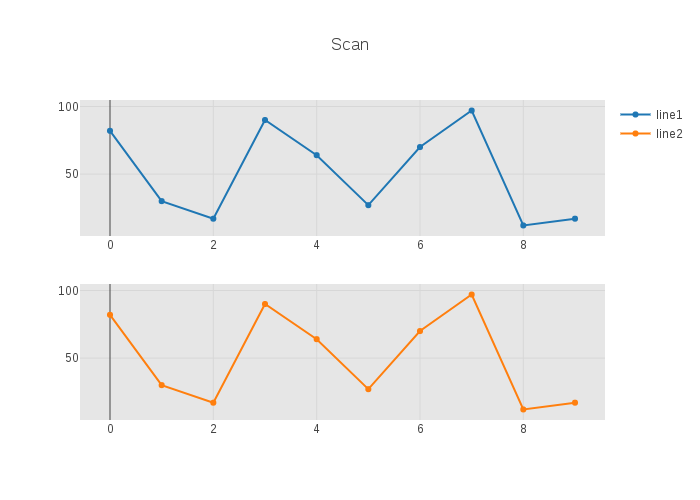

In [12]:
display(IPython.display.Image("./scans/plot_0090.png"))

NameError: name 'config' is not defined

Output()

Box()

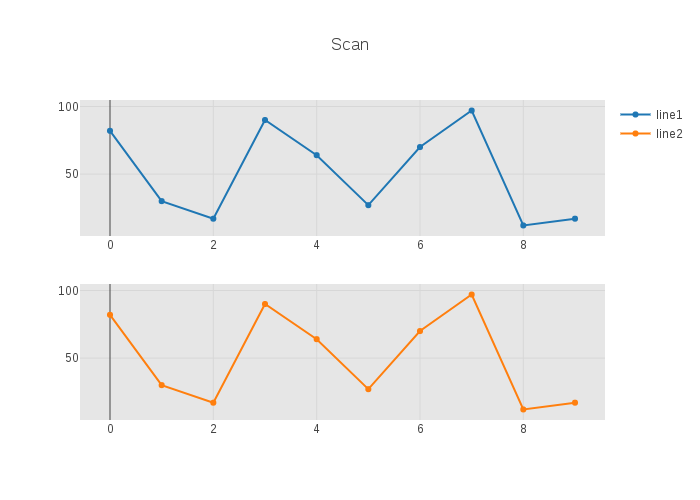

In [13]:
%tb
scan_save = MonitorScanSave(config)
scan_save.display_start_button()

In [ ]:
#%%script bash --bg
#!cd ~/work/scan-gui && ./scan_gui